Let's import our Kaggle API. It's expected to be placed in a kaggle folder, so we upload it and move that there.

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"raffaelebubbletea","key":"85ed99a684b59ccd2267322356af15c4"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!mkdir dog_dataset
%cd dog_dataset

/content/dog_dataset


In [ ]:
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                         size  lastUpdated                 downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  ----------  --------------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp   724495926  2020-06-26 03:09:05.433000           8117         10  0.1764706        


In [ ]:
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

Dataset URL: https://www.kaggle.com/datasets/catherinehorng/dogbreedidfromcomp
License(s): unknown
 96% 663M/691M [00:04<00:00, 42.9MB/s]
100% 691M/691M [00:04<00:00, 176MB/s] 
/content


In [ ]:
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv

Streaming output truncated to the last 5000 lines.
  inflating: dog_dataset/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: dog_dataset/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog_dataset/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog_dataset/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog_dataset/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog_dataset/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog_dataset/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog_dataset/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog_dataset/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog_dataset/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog_dataset/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog_dataset/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: dog_dataset/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: dog_dataset/train/840db91b

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam

In [ ]:
labels_all = pd.read_csv('dog_dataset/labels.csv')
print(labels_all.shape)
labels_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
#Let's see how many images we have for each breed
breeds_all = labels_all["breed"]
breed_counts = breeds_all.value_counts()
breed_counts.head()

,count
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114


In [ ]:
#Let's pick maybe 3 classes to train on
CLASS_NAMES = ['scottish_deerhound','maltese_dog','bernese_mountain_dog']
labels = labels_all[(labels_all['breed'].isin(CLASS_NAMES))]
labels.reset_index()
labels.head()

,id,breed
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
12,00693b8bc2470375cc744a6391d397ec,maltese_dog
79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
118,02d54f0dfb40038765e838459ae8c956,bernese_mountain_dog


In [ ]:
X_data = np.zeros((len(labels), 224, 224, 3), dtype='float32')
Y_data = label_binarize(labels['breed'], classes = CLASS_NAMES) #one hot encoding

#we convert the images to numpy arrays
for i in tqdm(range(len(labels))):
    img = image.load_img('dog_dataset/train/%s.jpg' % labels['id'].iloc[i], target_size=(224,224))
    img = image.img_to_array(img)
    x = np.expand_dims(img.copy(), axis=0)
    X_data[i] = x / 255.0

#Visualizing the train images data, and one hot encoding shape and size
print("\nTrain images shape: ", X_data.shape, " shape: {:,}".format(X_data.size))
print("One-hot encoded output shape: ", Y_data.shape, " size: {:,}".format(Y_data.size))

100%|██████████| 357/357 [00:00<00:00, 524.01it/s]


Train images shape:  (357, 224, 224, 3)  shape: 53,738,496
One-hot encoded output shape:  (357, 3)  size: 1,071


In [ ]:
#Building the model

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5,5), activation="relu", input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu", kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=16, kernel_size=(7,7), activation="relu", kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=8, kernel_size=(5,5), activation="relu", kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation="relu", kernel_regularizer='l2'))
model.add(Dense(64, activation="relu", kernel_regularizer='l2'))
model.add(Dense(len(CLASS_NAMES), activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer=Adam(0.0001), metrics=["accuracy"])
model.summary()








/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 220, 220, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 108, 108, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 16)     │        25,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 20, 20, 8)      │         3,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       102,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,619 (635.23 KB)

 Trainable params: 162,619 (635.23 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size=0.1)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size = 0.2)

In [ ]:
epochs = 100
batch_size = 128

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs,
                    validation_data = (X_val, Y_val))

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.3281 - loss: 4.8893 - val_accuracy: 0.5385 - val_loss: 4.8593
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 397ms/step - accuracy: 0.4583 - loss: 4.8570 - val_accuracy: 0.4462 - val_loss: 4.8360
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step - accuracy: 0.4375 - loss: 4.8313 - val_accuracy: 0.4462 - val_loss: 4.8121
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step - accuracy: 0.4531 - loss: 4.8025 - val_accuracy: 0.4154 - val_loss: 4.7889
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step - accuracy: 0.4531 - loss: 4.7760 - val_accuracy: 0.4154 - val_loss: 4.7660
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step - accuracy: 0.4661 - loss: 4.7464 - val_accuracy: 0.4154 - val_loss: 4.7433
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step - accuracy: 0.4505 - loss: 4.7210 - val_accuracy: 0.3846 - val_loss: 4.7199
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step - accuracy: 0.4922 - loss: 4.6831 - val_accuracy: 0.3385 - val

In [ ]:
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print("Accuracy over the test set: \n", round((score[1]*100),2), "%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 734ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step - accuracy: 0.6817 - loss: 3.6708
Accuracy over the test set: 
 69.44 %


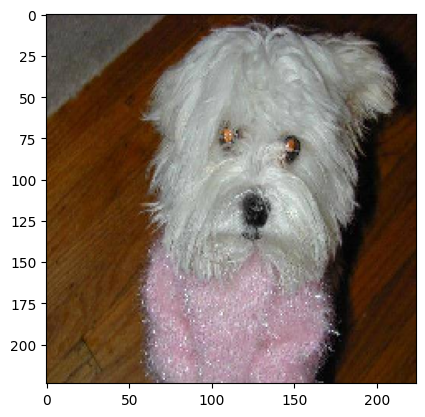

KeyError: np.int64(1)

In [ ]:
plt.imshow(X_test[1,:,:,:])
plt.show()

print("Originally: ", labels['breed'][np.argmax(Y_test[1])])
print("Predicted: ", labels['breed'][np.argmax(Y_pred[1])])

In [ ]:
model.save("dog_breed.h5")